# Visualizing Fires with False Color Images


### By Kaiju Morquecho

[Github Repository](https://github.com/kaimorquecho/eds220-hwk4.git)

## About

This notebook contains a python analysis and visualization of the data mentioned below, using false and true color imagery to show the burn areas of the January 2025 Palisades & Eaton fires in California.

### Purpose
The purpose of this notebook is to use `netCDF4` data files, accessed with the `xarray` library, to visualize the burn scars from the Eaton and Palisades fires that occurred in January of 2025. 

### Highlights
- Use the `xarray` library to streamline analysis of `netCDF4` files containing multidimensional data
- Use false color imagery to highlight burn areas after California wildfires 
- Address common remote sensing data issues such as extreme and `np.nan` values that distort data visualizations

### About the Data
- Fire perimeter data are sourced from the [eGIS LA County hub](ttps://egis-lacounty.hub.arcgis.com/maps/lacounty::palisades-and-eaton-dissolved-fire-perimeters-2025/about), and can be accessed and downloaded by selecting the desired layer and clicking 'Download'. Dataset for the layer `Eaton_Perimeter_20250121` contains the `.shp` file of the Eaton Fire dissolved perimeter, while `Palisades_Perimeter_20250121` contains the Palisades Fire dissolved perimeter. Both datasets are in the `EPSG:3857` `CRS`.

- Landsat data was provided by the course instructor, Dr. Carmen Galaz Garcia, as a simplified collection of bands (red, green, blue, near-infrared, and shortwave infrared). The data comes from the Landsat Collection 2 level-2 atmospherically corrected surface reflectance data, which is collected by the Landsat 8 satellite. The original data and other related datasets can be retrieved from the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2). The data is in the `EPSG:32611` `CRS`. 

### References
Los Angeles County GIS. (2025). Palisades and Eaton Dissolved Fire Perimeters (2025) [Data layer]. eGIS LA County Hub. https://egis-lacounty.hub.arcgis.com/maps/lacounty::palisades-and-eaton-dissolved-fire-perimeters-2025/about. Accessed November 22, 2025, via ArcGIS: https://www.arcgis.com/home/item.html?id=ad51845ea5fb4eb483bc2a7c38b2370c

Earth Resources Observation and Science (EROS) Center. (2025). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6. Accessed November 22, 2025, via Microsoft Planetary Computer: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2.

Galaz Garcia, C., & Adams, A. (2025). EDS 220: Working with environmental datasets [Course website]. University of California, Santa Barbara, Master of Environmental Data Science Program. https://meds-eds-220.github.io/MEDS-eds-220-course/

### Import Libraries and Load Datasets

Aside from the standard libraries such as `numpy` and `matplotlib`, the following specialized libraries were used in this analysis:
- `xarray` to access and analyze netCDF4 files (multidimensional datasets)
- `rioxarray` to extend `xarray` with the `rio` accessor to read and manipulate raster data 
- `contextily` to add basemaps to geospatial visualizations
- `geopandas` to handle vector data such as shapefiles

In [22]:
# Import Libraries

import os
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr   
import rioxarray as rioxr
import contextily as ctx

### Import Data 

In [2]:
# Import Data 

# Fire Perimeter Data
eaton = gpd.read_file(os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp')) # Eaton Fire Perimeter
palisades = gpd.read_file(os.path.join('data','Palisades_Perimeter_20250121','Palisades_Perimeter_20250121.shp')) # Palisades Fire Perimeter

# Landsat NetCDF File
landsat = xr.open_dataset(os.path.join('data','landsat8-2025-02-23-palisades-eaton.nc'))

### Explore Fire and Landsat Datasets
I begin the analysis by exploring the datasets I will use to understand their structure and contents. It is important to be familiar with the dimensions, variables, indexes,and attributes of the `NetCDF4` file. `NetCDF4` files, in particular, can contain multiple variables stored as multidimensional arrays, along with metadata that describes the data.

### Landsat Data Exploration

In [3]:
# Explore landsat data (see attributes, variables, and dimensions)
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

In [4]:
# Check units of landsat data coordinates 
print(f'x coordinates have unit: {landsat["x"].attrs.get("units")}')
print(f'y coordinates have unit: {landsat["y"].attrs.get("units")}')

x coordinates have unit: metre
y coordinates have unit: metre


### Landsat Data Exploration Summary
I explore the Landsat `NetCDF` `xaaray` dataset (`landsat8-2025-02-23-palisades-eaton.nc`), which contains multiple variables: spectral bands (red, green, blue, nir08, swir22) stored as 2D arrays with dimensions (1418,2742) collected by the Landsat 8 satellite. The dataset includes a time coordinate (containing just one value given that the data is from Feb 23, 2025) and a spatial_ref attribute. Both x and y coordinates are in metres, confirming that the data is projected in a UTM projected coordinate system. 

### Fire Perimeter Data Exploration

I explore the fire perimeter data to find their CRS, compatibility with one another, and other relevant attributes.

In [5]:
# Check Eaton fire perimeter data's CRS 
print(eaton.crs)

# Verify that Eaton fire perimeter data is on same CRS as the Palisades fire perimeter data
assert(eaton.crs==palisades.crs) # Assert test confirms that they are on the same CRS system (EPSG 3857)

EPSG:3857


In [6]:
# Check if Eaton and Palisades datasets are projected
print(f"The Eaton fire perimeter dataset projected: {eaton.crs.is_projected}")
print(f"The Palisades fire perimeter dataset projected: {palisades.crs.is_projected}")


The Eaton fire perimeter dataset projected: True
The Palisades fire perimeter dataset projected: True


In [7]:
# Check Eaton dataset's columns and their data types
eaton.dtypes

OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object

In [8]:
# Check Palisades dataset's columns and their data types
palisades.dtypes

OBJECTID         int64
type            object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object

Text(0.5, 1.0, 'Eaton Fire Perimeter')

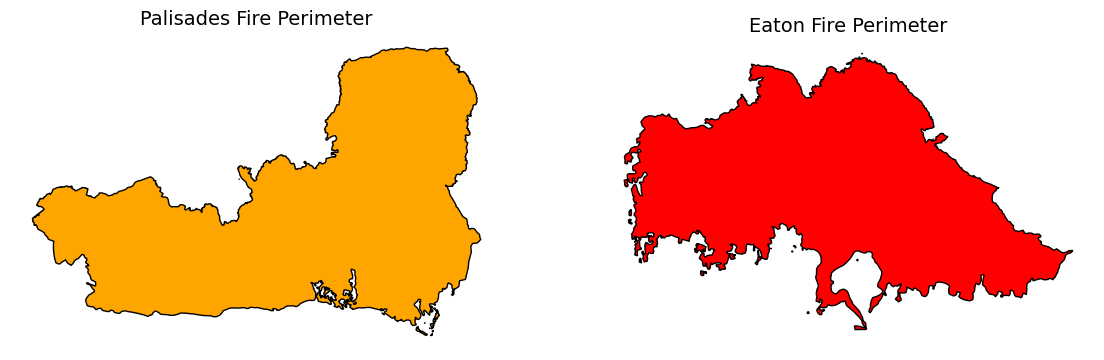

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax2.axis('off')
ax1.axis('off')

palisades.plot(ax=ax1, color='orange', edgecolor='black')
eaton.plot(ax=ax2, color='red', edgecolor='black')
ax1.set_title('Palisades Fire Perimeter', fontsize=14)
ax2.set_title('Eaton Fire Perimeter', fontsize=14)

### Fire Perimeter Data Exploration Summary

I explore the fire perimeter datasets for both the Eaton and Palisades fires, obtained from LACounty’s ArcGIS Hub. The datasets contain the dissolved fire perimeters, as of January 21, 2025, share the same coordinate reference system (`EPSG 3857`), and are projected. Each dataset contains columns for `OBJECTID`, `type`, `Shape__Are`, `Shape__Len`, and `geometry`. It is interesting and alarming to see how extensive the fires (and therefore, their perimeters) were, especially given that they gained so much territory within 24 hours.

### Restore Landsat Geospatial Information

In [10]:
# Check dataset's CRS
print(landsat.rio.crs)

None


While we cannot access the `CRS` in `Landsat`, that does not mean the dataset is **not** a geospatial object. I can access the `spatial_ref.crs_wkt` attribute of the dataset and print the `CRS`.

In [11]:
# Access and extract spatial_ref.crs_wkt attribute and store in variable
landsat_crs = landsat.spatial_ref.crs_wkt

type(landsat_crs) # Check that it is an acceptable object for next step

str

In [12]:
# Use rio.write_crs() to recover the geospatial information 
landsat.rio.write_crs(landsat_crs, inplace=True)

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...

In [13]:
# Check that dataset has been updated with the CRS
print(landsat.rio.crs)

EPSG:32611


### Plot a True Color Image Using Landsat Data
This type of image approximates what the human eye would see on the ground, making it useful for gaining an intuitive understanding of the landscape: identifying vegetation, urban areas, water, and cloud cover.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


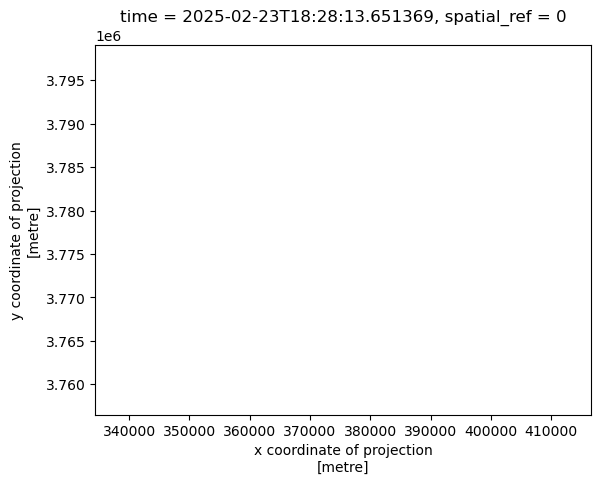

In [14]:
landsat[['red','green','blue']].to_array().plot.imshow()

The true color image looks blank due to the RGB values of the clouds. Their values are outliers that are causing the other RGB values to be squished when plotting. To fix this, I adjust the `robust` paramater of the `imshow()` method.

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


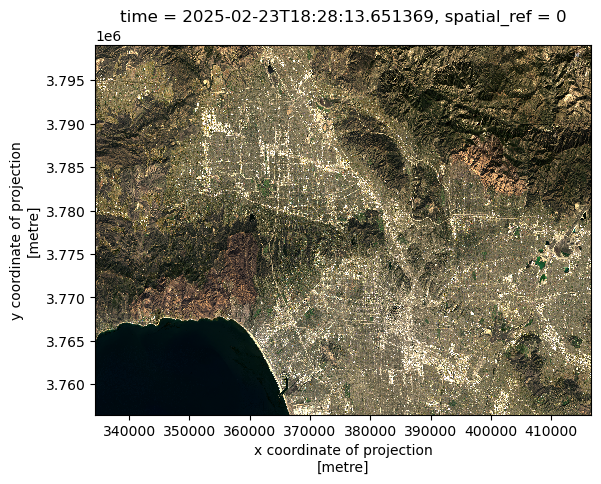

In [15]:
landsat[['red','green','blue']].to_array().plot.imshow(robust = True)

To resolve the `RuntimeWarning: invalid value encountered in cast xx = (xx * 255).astype(np.uint8)` warning, identify the bands with `nan` values, which `.plot.imshow()` sees as invalid.

In [16]:
# use isnan() and .sum() to find the sum of nans in each band in landsat dataset
nan_mask = np.isnan(landsat[['red','green','blue']].to_array()).sum(dim=['y','x'])

In [17]:
# Print the results by band
for band, count in zip(nan_mask['variable'].values, nan_mask.values):
    print(f'{band} band has {count} nans')

red band has 0 nans
green band has 1 nans
blue band has 109 nans


Next, I use `fillna()` to replace `nans` with zeros to resolve the other warning and visualize again

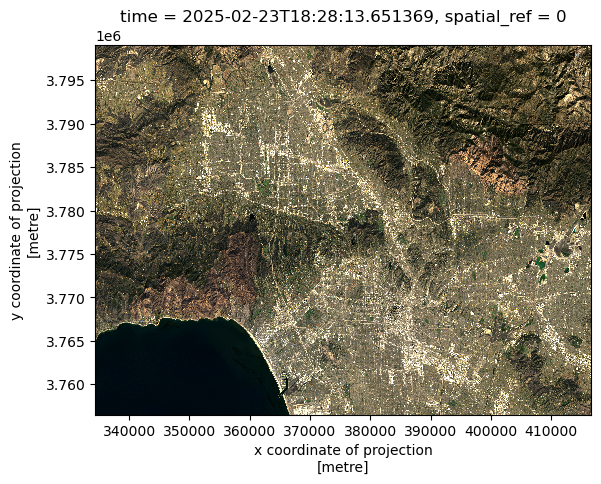

In [18]:
landsat[['red','green','blue']].fillna(value=0).to_array().plot.imshow(robust=True)

### Initial and final true color image comparison:

Initial attempt to plot the true color image raised two warnings and produced a white image. The first warning was due to extreme values (likely clouds) in the landsat data. These values were extreme RGB outliers that squished other RGB values. The second warning was due to np.nan values, which were invalid values for xarray. I resolved the first warning by adjusting the `robust` paramater of the `imshow()` method, and the second by replacing the np.nan values with zeros. After this, the true color image was accurate and without warnings.

### False Color Image
False color imagery is particularly useful for highlighting specific features in the landscape, such as vegetation health, water bodies, and burn areas from wildfires. In this case, I use the near-infrared (NIR), red, and green bands to create a false color composite that emphasizes vegetation and burn scars.

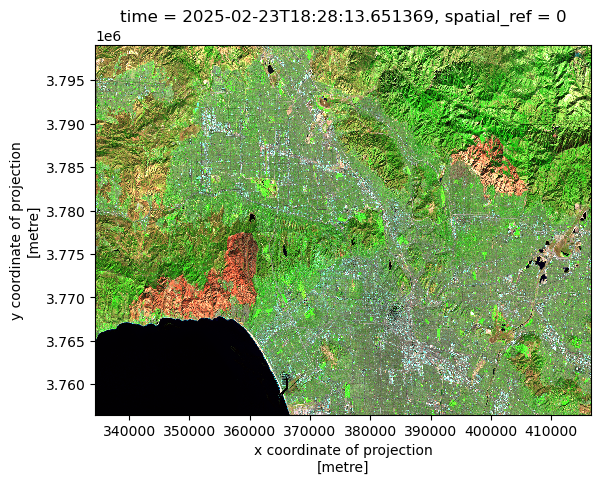

In [19]:
# Plot a false color image using landsat data variables 'swir22','nir08', and 'red' (short-wave infrared, near-infrared, and red band)
landsat[['swir22','nir08','red']].fillna(value=0).to_array().plot.imshow(robust=True)

### Map False Color Image and Fire Perimeters
I plot the false color image using the NIR, red, and green bands, and overlay the fire perimeters for both the Eaton and Palisades fires. I also add a basemap for context.

In [20]:
# Update Eaton and Palisades crs to landsat dataset's crs before plotting 
eaton = eaton.to_crs(landsat.rio.crs)

palisades = palisades.to_crs(eaton.crs)

# Assert that datasets are now on same crs
assert(eaton.crs == palisades.crs == landsat.rio.crs)

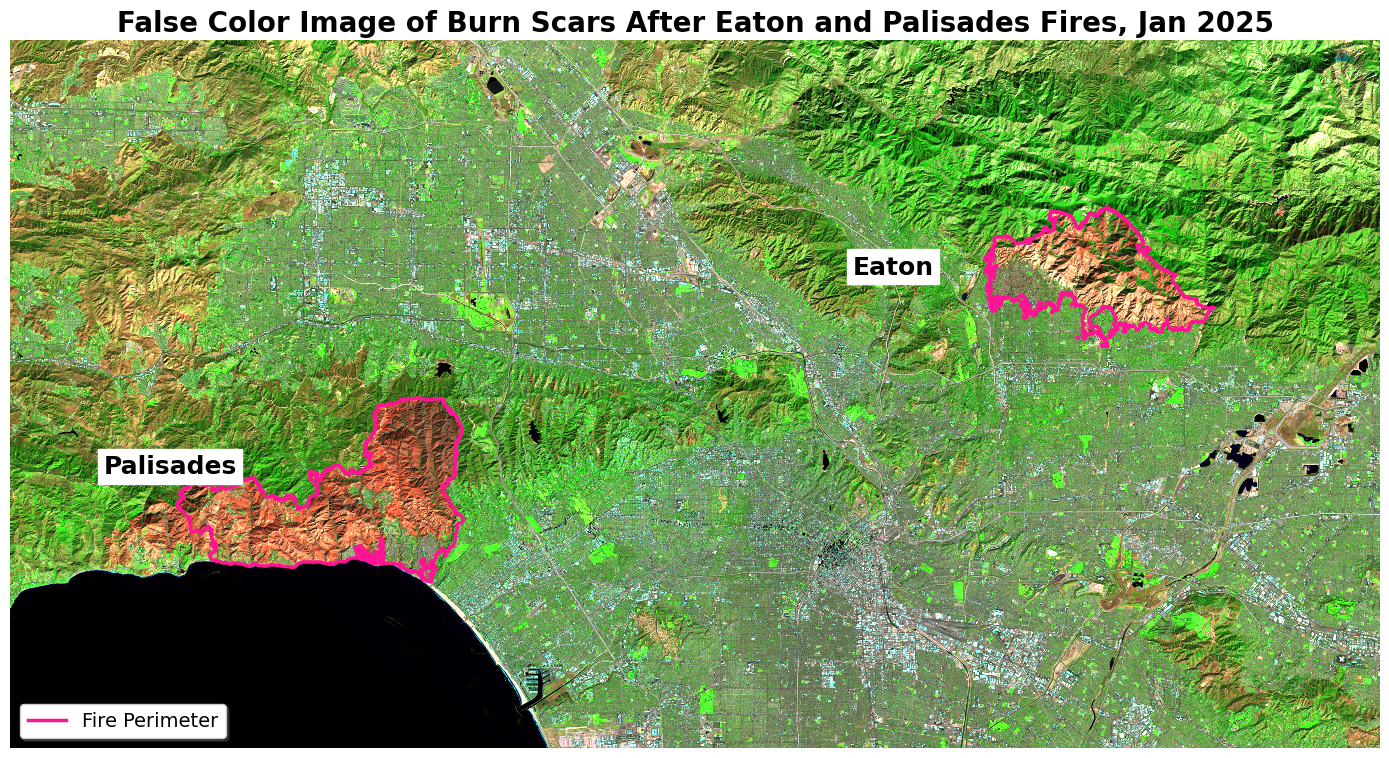

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

landsat[['swir22','nir08','red']].fillna(value=0).to_array().plot.imshow(robust=True,
                                                                        ax=ax) # Landsat image
eaton.plot(ax=ax, # Eaton fire perimeter
          color = 'none',
          edgecolor = 'deeppink',
          linewidth = 2.5)

palisades.plot(ax=ax, # Palisades fire perimeter
              color = 'none',
              edgecolor = 'deeppink',
              linewidth = 2.5)

# Label fire perimeters
ax.text(x=385000, y=3785000, s="Eaton", fontsize=18, color='black', weight='bold', backgroundcolor = 'white') 
ax.text(x=340000, y=3773000, s="Palisades", fontsize=18, color='black', weight='bold', backgroundcolor = 'white')

# Create a legend for the fire perimeters
fire_line = Line2D([0], [0], color='deeppink', linewidth=2.5, label='Fire Perimeter')
ax.legend(handles=[fire_line], loc='lower left', fontsize=14, facecolor='white', shadow=True)

ax.set_title('False Color Image of Burn Scars After Eaton and Palisades Fires, Jan 2025',
            fontsize = 20,
            weight='bold')

ax.axis('off')

plt.tight_layout()
plt.show()

### Burn Scars After Eaton and Palisades Fires, Jan 2025 Map Description:
The map above is a false-color visualization created using short-wave infrared (SWIR), near-infrared (NIR), and red bands, assigned to the red, green, and blue channels respectively. This band combination highlights vegetation and burn scars, with recently burned areas appearing in deep magenta or dark tones. On top of the map, I plotted the perimeters of the Eaton and Palisades burn areas using the color `darkorchid` to clearly outline their locations.